In [1]:
# Author Emmanuel Sedicol
from imutils.video import VideoStream
from imutils.video import FPS
import numpy as np
import argparse
import cv2
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf
from YOLO import yolo

from IPython.display import clear_output

shot_xy_coordinates = []
player_xy_coordinates = []
ball_xy_coordinates = []

orangeLower = (1, 80, 110)
orangeUpper = (8,200,175)

CATEGORIES = ['basketball', 'hoop']
model = tf.keras.models.load_model("MODEL")

# Inner Functions
#### predict_object(frame):
- transform input frame to the corect structure before being classified my the model

#### color_detection(hsv,lower,higher):
- creates a mask using input frame and returns contours

In [2]:
# prepare the detected frame for classification
def predict_object(frame):
    img = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (80,80))
    img = img.reshape(-1, 80, 80, 1)
    
    # predict image
    prediction = model.predict([img])
    prediction_label = CATEGORIES[int(prediction[0][0])]
    return(prediction_label)

# color detection is lower and upper hsv range
def color_detection(hsv,lower,higher):
    # create mask to detect the orange only
    mask = cv2.inRange(hsv, lower, higher)

    # find contours in the mask and initialize the current
    cnts = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts

# Main Function

In [18]:
# main function
def main_app(video_path):
    # read video file
    vs = cv2.VideoCapture(video_path)
    fps = FPS().start()
    
    while True:
        # grab the current frame
        _,frame = vs.read()

        # break out of the application if we have no more frames to read
        if frame is None:
            break

        # resize frame so to make its constant size througout
        frame = cv2.resize(frame,(600, 450))
        detected_object = frame.copy()

        # detect person using YOLO
        target = "person"
        yolo.yolo_detection(target, frame)

        # retrieve player coordinate on the court using YOLO
        x_coor, y_coor = yolo.xy_personCoordinate(frame)
        
        # save coordinates
        player_xy_coordinates.append((int(x_coor), int(y_coor)))
        np.savetxt('/Users/esedicol/Desktop/Desktop/Basketball-Shot-Detectection/COORDINATES/person_xy_coord.txt', player_xy_coordinates, fmt='%d')

        # retrieve ball coordinate on the court using YOLO
        bx_coord, by_coord = yolo.xy_ballCoordinate(frame)
        ball_xy_coordinates.append((int(bx_coord), int(by_coord)))
        
        # frame filtering and image processing
        blur = cv2.GaussianBlur(frame, (15, 15),0)
        erode = cv2.erode(blur, None, iterations=2)
        dilate = cv2.dilate(erode, None, iterations=2)
        hsv = cv2.cvtColor(dilate, cv2.COLOR_BGR2HSV)

        # detect basketball using its color (i.e. orange)
        cnts = color_detection(hsv,orangeLower,orangeUpper)
        
        # Retrieve the largest contour in the mask, then use it to compute the minimum enclosing circle and centroid
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)

        if  len(cnts) > 0:      
            # only proceed if the radius meets a minimum size
            if radius > 0 and radius < 30 :
                # Retrive the frame of detected ball
                detected_object = detected_object[int(y - 20):int(y + 20),int(x - 20):int(x + 20)] 
                
                # detect ball using YOLO
                if len(ball_xy_coordinates) > 0:
                    target_b = "ball"
                    yolo.yolo_detection(target_b, frame)
                   
                # detect ball using the model I built
                if predict_object(detected_object) == "basketball" :
                    # Append (x,y) coordinates and plot them later
                    shot_xy_coordinates.append((x,y))
                    np.savetxt('/Users/esedicol/Desktop/Desktop/Basketball-Shot-Detectection/COORDINATES/shot_xy_coord.txt', shot_xy_coordinates, fmt='%d')

                    # Draw the circle and centroid on the frame,
                    cv2.circle(frame, (int(x), int(y)), int(radius),(0, 255, 255), 2)
                    cv2.circle(frame, (int(x), int(y)), 1, (0, 0, 255), 2)

                    # Draw rectangle around the minimum enclosed circle and dipslay label of detected object
                    cv2.rectangle(frame, (int(x - 20), int(y - 20)), (int(x + 20), int(y + 20)), (255,0,0), 2)
                    cv2.putText(frame, "BASKETBALL", (int(x - 30), int(y - 25)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1 )

        # plot results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
        fig.suptitle('Basketball and Player Detection')
        ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        # plot at realtime the shot coordinates
        for x in range(0, len(shot_xy_coordinates)):
            ax2.scatter(shot_xy_coordinates[x][0], shot_xy_coordinates[x][1])
            
        ax2.set_xlim(0, 600)
        ax2.set_ylim(0,400)
        ax2.invert_yaxis()
        
        ax1.axis("off")
        plt.show()
        clear_output(wait=True)

    fps.stop()
    print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

    vs.release()

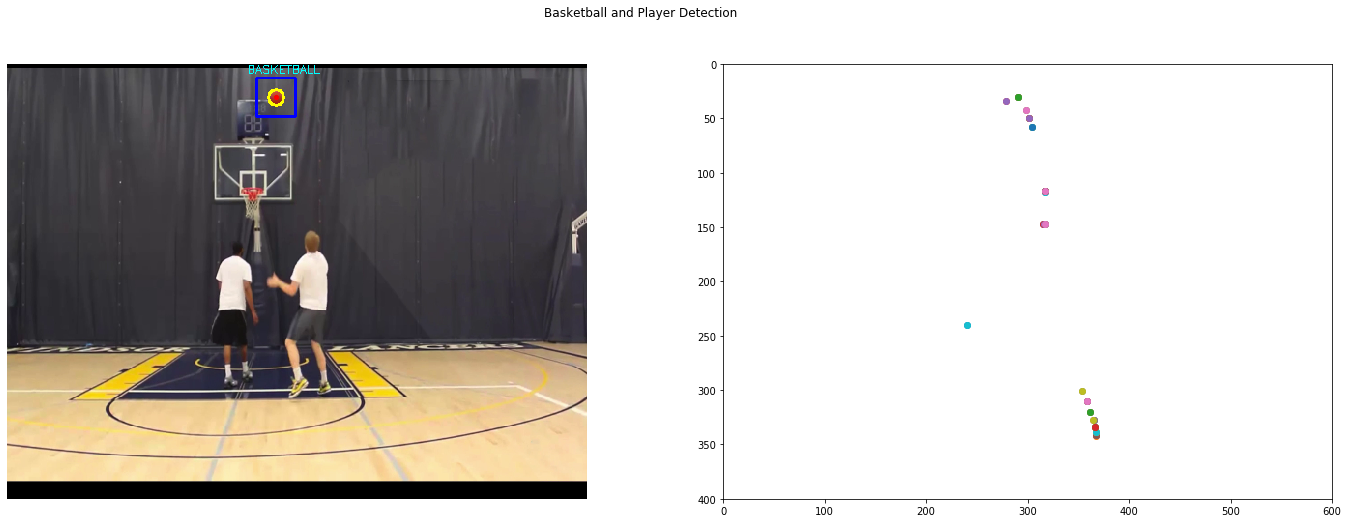

In [ ]:
if True:
    file = "VIDEOS/MAIN_TEST2.mov"
    main_app(file)